# Digital Asset Data Tech Eval

The objective of this project is to design a predictive model that Digital Asset Data could offer to clients.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import mlutils as mlu
%matplotlib inline

np.random.seed(11)

In [2]:
# Load dataset into memory
block_data = pd.read_csv('blockchain_data.csv')
market_data = pd.read_csv('market_data.csv')

## Exploratory Data Analysis
In the following section, the data is checked for obvious errors, scale problems, stationarity, missingness, and possible features to be used for the predictive model. 

In [3]:
market_data.head(3)

,base_asset_id,quote_asset_id,epoch_ts,price_open,price_high,price_low,price_close,price_mean_a,price_std,price_vwap_a,price_vwap_h,cnt_total,volume_total,volume_high,volume_low,volume_mean_a,volume_std
0,Bitcoin_BTC_BTC,USDollar_USD_USD,2019-02-19 00:00:00+00,3932.714647,4093.592472,3841.540000,3947.838332,3982.976819,42.843054,3992.851593,3992.331372,505918,1.016199e+05,3.309573e+02,1.800000e-09,0.245708,1.312071
1,Cardano_ADA_ADA,USDollar_USD_USD,2019-02-19 00:00:00+00,0.046611,0.051831,0.044664,0.046850,0.047804,0.000686,0.047779,0.047767,89496,4.697049e+08,1.680672e+06,1.000000e-01,6162.362937,18885.346700
2,Dash_DASH_DASH,USDollar_USD_USD,2019-02-19 00:00:00+00,87.616371,91.952000,85.849339,88.389405,88.486393,0.926142,88.470100,88.459994,23643,3.341039e+04,2.255077e+02,1.000000e-08,1.737967,5.353673


In [4]:
block_data.head(3)

,asset_id,epoch_ts,volume_sum,volume_high,volume_low,volume_mean_q,volume_mean_a,volume_mean_g,volume_mean_h,volume_std,...,fee_high,fee_low,fee_mean_q,fee_mean_a,fee_mean_g,fee_mean_h,fee_std,block_reward_sum,supply_total,blockchain_size
0,Bitcoin_BTC_BTC,2019-02-19 00:00:00+00,1.780234e+06,11837.005536,0.0,74.281965,5.112060,0.054446,1.404571e-03,74.105958,...,0.055191,0.0,0.000445,0.000105,0.000039,0.000016,0.000433,1950.000000,1.754774e+07,193912854133
1,Dash_DASH_DASH,2019-02-19 00:00:00+00,3.388989e+05,12879.641105,0.0,324.575946,23.654558,0.173700,3.251968e-03,323.724144,...,0.037780,0.0,0.001894,0.000206,0.000009,0.000007,0.001883,1850.115799,8.310922e+06,8295434127
2,Ethereum_ETH_ETH,2019-02-19 00:00:00+00,2.787835e+06,28467.000000,0.0,137.359364,5.180472,0.223269,8.359763e-15,137.261767,...,0.160157,0.0,0.012248,0.004436,0.001707,0.001073,0.011416,13536.031250,3.327931e+07,73831306948


In [5]:
# Rename asset_id column
market_data = market_data.rename(columns={'base_asset_id':'asset_id'})

In [6]:
# Merge block_data into market_data
new_data = market_data.merge(block_data,how='left',on=['asset_id','epoch_ts'])

In [7]:
# Create datetime index from 'epoch_ts' column and sort ascending
new_data.index = [pd.to_datetime(x[:10]) for x in new_data['epoch_ts']]
new_data = new_data.sort_index()

In [8]:
# View data missingness
grouped = new_data.groupby('asset_id')
asset_name = [at for at,df in grouped]
pd.DataFrame([(df.isna().sum(0)) for at,df in grouped], index=asset_name)

,asset_id,quote_asset_id,epoch_ts,price_open,price_high,price_low,price_close,price_mean_a,price_std,price_vwap_a,...,fee_high,fee_low,fee_mean_q,fee_mean_a,fee_mean_g,fee_mean_h,fee_std,block_reward_sum,supply_total,blockchain_size
Bitcoin_BTC_BTC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Cardano_ADA_ADA,0,0,0,0,0,0,0,0,0,0,...,413,413,413,413,413,413,413,413,413,413
Dash_DASH_DASH,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
EOS_EOS_EOS,0,0,0,0,0,0,0,0,0,0,...,415,415,415,415,415,415,415,415,415,415
Ethereum_ETH_ETH,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Litecoin_LTC_LTC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NEO_NEO_NEO,0,0,0,0,0,0,0,0,0,0,...,415,415,415,415,415,415,415,415,415,415
Ripple_XRP_XRP,0,0,0,0,0,0,0,0,0,0,...,415,415,415,415,415,415,415,415,415,415
Stellar_XLM_XLM,0,0,0,0,0,0,0,0,0,0,...,415,415,415,415,415,415,415,415,415,415
TRON_TRX_TRX,0,0,0,0,0,0,0,0,0,0,...,415,415,415,415,415,415,415,415,415,415


There is a lot of missing data. The most well known coins have blockchain data and analysis will proceed with those assets only. On a longer project, more emphasis on data acquisition and cleaning would be done.

In [9]:
# Drop NA rows
new_data = new_data.dropna()

In [10]:
# Drop string columns
new_data = new_data.drop(['quote_asset_id','epoch_ts'], axis=1)

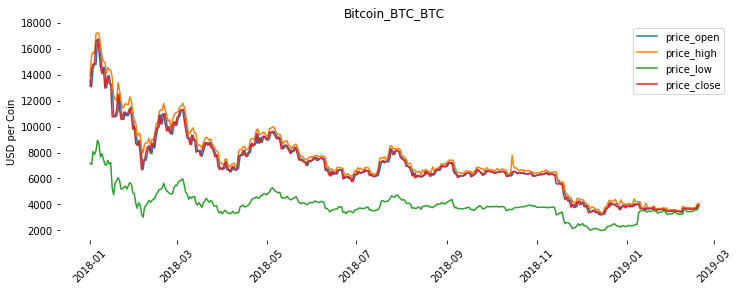

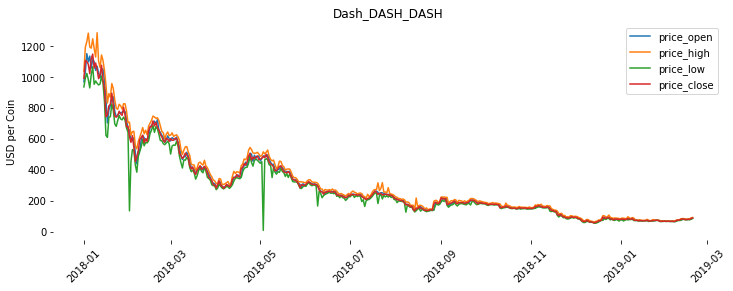

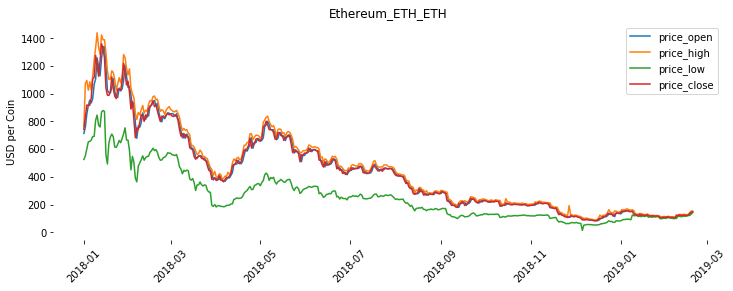

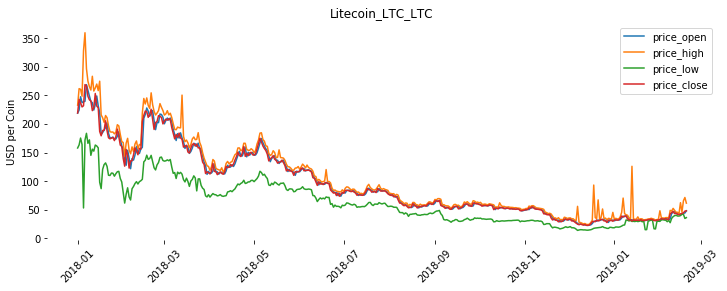

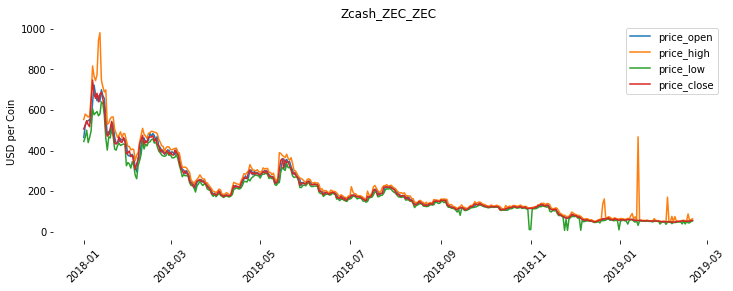

In [11]:
# Visual check for obvious bad data in prices
grouped = new_data.groupby('asset_id')
for t,df in grouped:
    plt.figure(figsize=(12,4))
    for icol in range(1,5):
        dat = df.iloc[:, icol]
        plt.plot(dat, label=dat.name)
    plt.title(t)
    plt.ylabel('USD per Coin')
    plt.legend()
    plt.xticks(rotation=45)
    sns.despine(left=True, bottom=True)
    plt.show()

From the charts above, you can clearly see there are widespread data problems for 'price_low' and some problems with 'price_high'. The 'price_close' data does not immediately exhibit the same issues. Normally data cleaning would be necessary at this point. Because this is a short project, bad data will be ignored and 'price_close' will be used to develop a model. 
 
As an experiment, let's develop a prediction model that can predict if a trader will hit a profit target, stop loss, or time stop first. The model will take the long side, but the price barriers will be symmetric, so the model will be just as affective for short trades. The small number of samples calls for techniques to deal with overfitting. Part of the experiment will be to observe if transfer learning between assets is viable. If so, the much larger number of training samples will make the model more accurate.

In [12]:
# Remove 'price_low' as it is obviously needs cleaning prior to being used in a model
new_data = new_data.drop(['price_low','price_high'],axis=1)

In [13]:
# Set parameters (sl factor, pt factor, time stop in days)
ptSlTs = [1,1,5]
# For each coin create triple barrier labels
new_data.loc[:,'label'] = new_data.groupby('asset_id')['price_close'].transform(mlu.applyPtSl,ptSlTs)

In [14]:
# Separate data and store in dictionary
data_dict = {}

for i in set(new_data['asset_id']):
    mask = np.where(new_data['asset_id'] == i)[0]
    data_dict[i] = new_data.iloc[mask,1:]

The next step before training any model is to make sure our price series are stationary. Normally, log returns or integer differencing is done. The method used here is fractional differentiation. This will preserve as much memory as possible while still making the data stationary. 

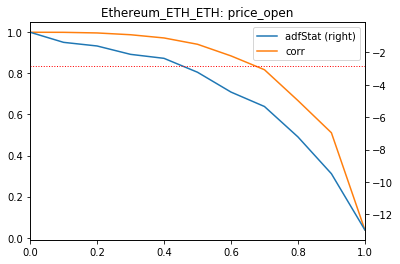

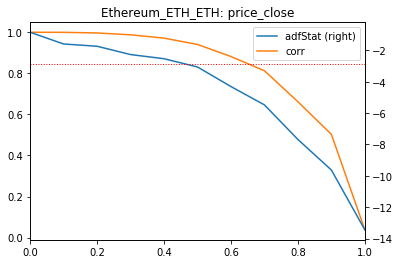

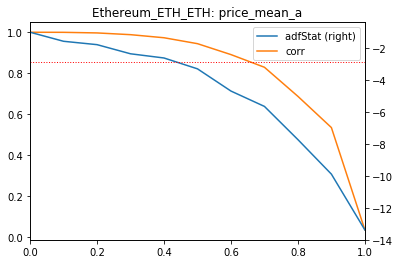

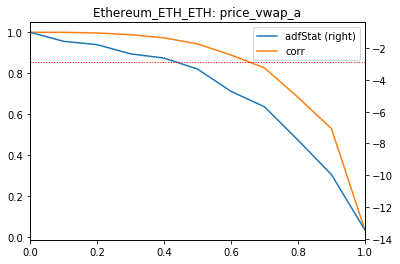

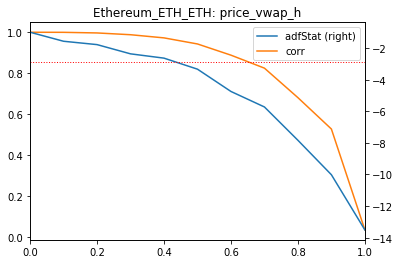

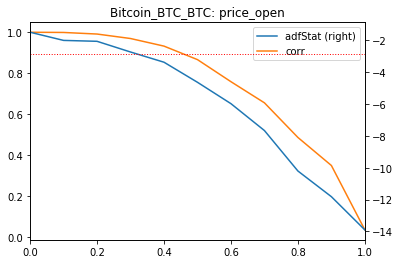

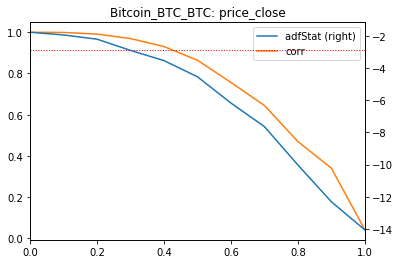

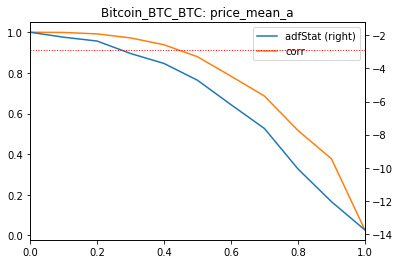

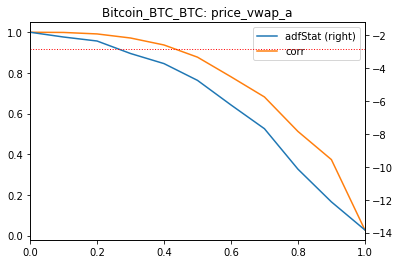

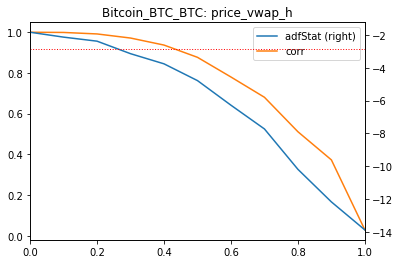

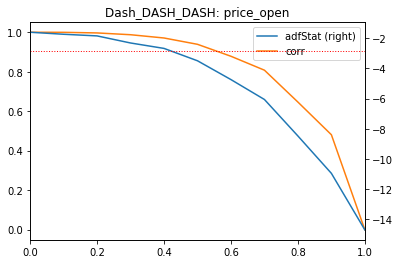

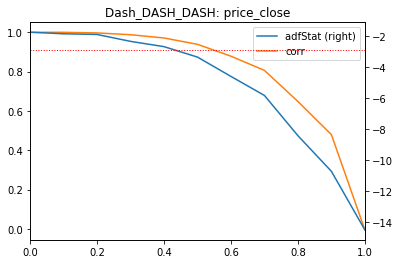

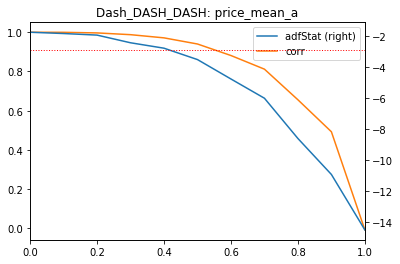

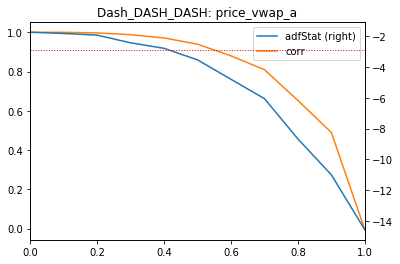

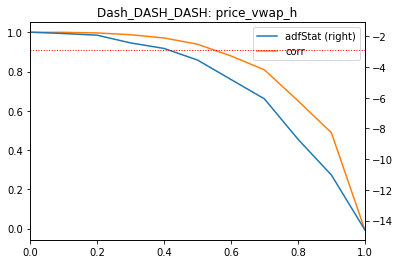

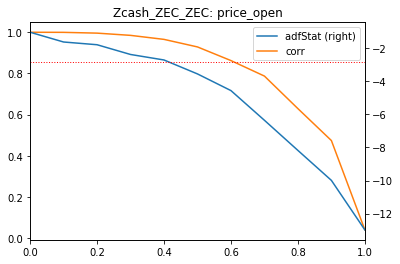

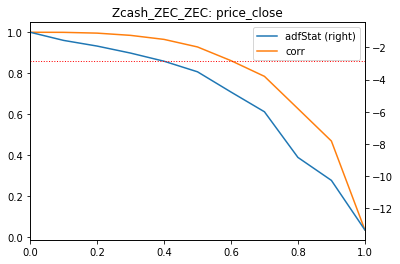

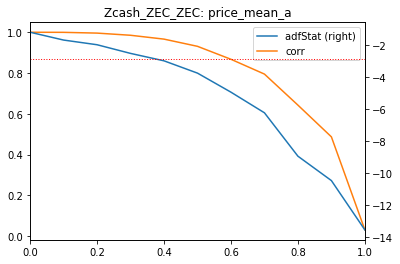

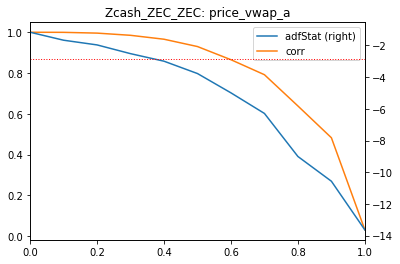

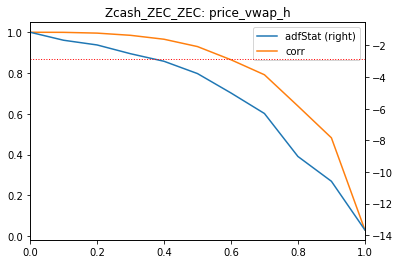

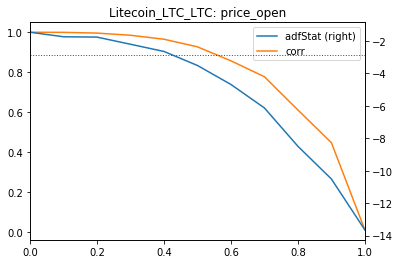

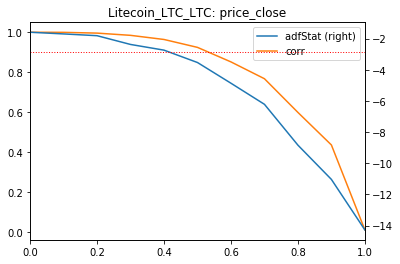

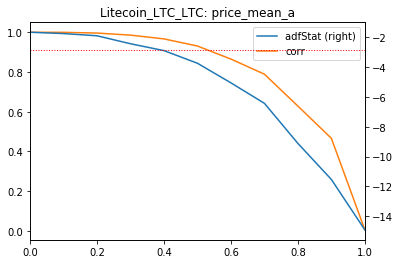

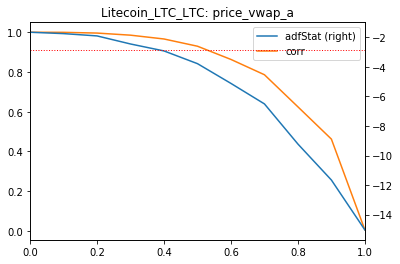

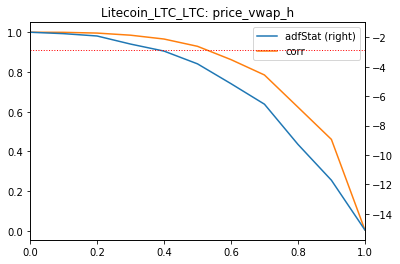

In [15]:
# Check for stationarity in prices and minimum differentiation to remove it
for at in data_dict:
    for i in data_dict[at].columns:
        if ('price' in i) and ('std' not in i):
            mlu.plotMinFFD(data_dict[at],i)
            plt.title(str(at) + ': ' + str(i))
            plt.show()         

The charts above show that most of the price series need to be differentiated. The horizontal red line shows the 95% confidence level where the adfStat crosses it. Most of the series only need to be fractionally differentiated. On a longer project, each series would be differentiated minimally to preserve as much memory in the series as possible. Here, one value will be used for all price series.

In [16]:
# Fractionally differentiate data to remove stationarity while preserving memory
# Save Sample for comparison
samp = data_dict['Bitcoin_BTC_BTC'][['price_close']]
for at in data_dict:
    for i in data_dict[at].columns:
        if ('price' in i) and ('std' not in i):
            data_dict[at][[i]] = mlu.fracDiff_FFD(data_dict[at][[i]],d=.65,thres=.01)

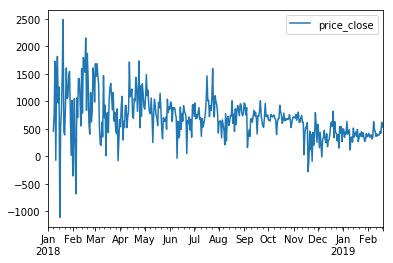

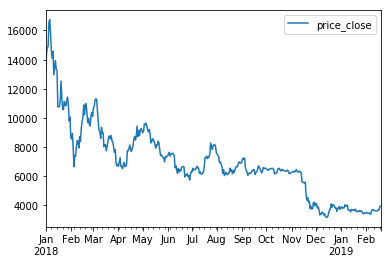

In [17]:
# Visualization of fractional differencing
data_dict['Bitcoin_BTC_BTC'][['price_close']].plot()
samp.plot()

In [18]:
# Check to see if class imbalance warrants additional data augmentation or other techniques
new_data.groupby('asset_id')['label'].value_counts(normalize=True)

asset_id          label
Bitcoin_BTC_BTC   sl       0.390361
                  t1       0.308434
                  pt       0.301205
Dash_DASH_DASH    sl       0.424096
                  t1       0.322892
                  pt       0.253012
Ethereum_ETH_ETH  sl       0.402410
                  pt       0.310843
                  t1       0.286747
Litecoin_LTC_LTC  sl       0.409639
                  pt       0.320482
                  t1       0.269880
Zcash_ZEC_ZEC     sl       0.443373
                  pt       0.298795
                  t1       0.257831
Name: label, dtype: float64

There is a class imbalance, but it is not extreme enough to need to use SMOTE or other sampling techniques at this time. Class weights will be used in training instead. 

The prediction model we will use is a neural net using LSTM cells. 

In [19]:
# Split into train/test and scale
X_train, X_test_bit, y_train, y_test_bit = mlu.splitscalewindow(data_dict['Bitcoin_BTC_BTC'].dropna(), split=.8)

# Build LSTM model
model = mlu.build_LSTM([X_train.shape[1],X_train.shape[2]],y_train.shape[1])

# View Model
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5, 38)             10944     
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 38)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 38)             11704     
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 38)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 24)                6048      
_________________________________________________________________
dropout_3 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 75        
Total para

In [20]:
# Get class weight balancers
class_weights_bal = mlu.getbalclassweights(y_train)

# Fitting the model
epochs = 50
batch_size = 128
history = model.fit(X_train, y_train, validation_data=(X_test_bit,y_test_bit), 
                    epochs = epochs, class_weight = class_weights_bal, 
                    batch_size = batch_size, verbose=0)

Train on 326 samples, validate on 77 samples
Epoch 1/50
326/326 [==============================] - 4s 13ms/step - loss: 3.3501 - val_loss: 1.1470
Epoch 2/50
326/326 [==============================] - 0s 542us/step - loss: 3.3469 - val_loss: 1.1467
Epoch 3/50
326/326 [==============================] - 0s 492us/step - loss: 3.3406 - val_loss: 1.1468
Epoch 4/50
326/326 [==============================] - 0s 475us/step - loss: 3.3425 - val_loss: 1.1464
Epoch 5/50
326/326 [==============================] - 0s 466us/step - loss: 3.3334 - val_loss: 1.1460
Epoch 6/50
326/326 [==============================] - 0s 470us/step - loss: 3.3283 - val_loss: 1.1451
Epoch 7/50
326/326 [==============================] - 0s 494us/step - loss: 3.3204 - val_loss: 1.1441
Epoch 8/50
326/326 [==============================] - 0s 492us/step - loss: 3.3124 - val_loss: 1.1424
Epoch 9/50
326/326 [==============================] - 0s 549us/step - loss: 3.3042 - val_loss: 1.1415
Epoch 10/50
326/326 [=================

In [21]:
# Check to see how well the model is classifying
print(mlu.class_report(X_test_bit, y_test_bit, model))

              precision    recall  f1-score   support

          pt       0.50      0.18      0.27        22
          sl       0.20      0.18      0.19        22
          t1       0.47      0.70      0.56        33

   micro avg       0.40      0.40      0.40        77
   macro avg       0.39      0.35      0.34        77
weighted avg       0.40      0.40      0.37        77



The classification results are far from impressive, but with no feature engineering and no hyper-parameter tuning, this is a good start. Let's proceed to train the same model on the other assets to see if transfer learning will help. Normally this would be done in a pipeline, but for ease of readability, models will be trained sequentially below. 

In [22]:
# Split into train/test and scale
X_train, X_test, y_train, y_test = mlu.splitscalewindow(data_dict['Litecoin_LTC_LTC'].dropna(), split=.8)

# Get class weight balancers
class_weights_bal = mlu.getbalclassweights(y_train)

# Fitting the model with another asset class
model.fit(X_train, y_train, epochs=epochs, class_weight=class_weights_bal, batch_size=batch_size, verbose=0)

In [23]:
# Split into train/test and scale
X_train, X_test, y_train, y_test = mlu.splitscalewindow(data_dict['Zcash_ZEC_ZEC'].dropna(), split=.8)

# Get class weight balancers
class_weights_bal = mlu.getbalclassweights(y_train)

# Fitting the model with another asset class
model.fit(X_train, y_train, epochs=epochs, class_weight=class_weights_bal, batch_size=batch_size, verbose=0)

In [24]:
# Split into train/test and scale
X_train, X_test, y_train, y_test = mlu.splitscalewindow(data_dict['Ethereum_ETH_ETH'].dropna(), split=.8)

# Get class weight balancers
class_weights_bal = mlu.getbalclassweights(y_train)

# Fitting the model with another asset class
model.fit(X_train, y_train, epochs=epochs, class_weight=class_weights_bal, batch_size=batch_size, verbose=0)

In [25]:
# Split into train/test and scale
X_train, X_test, y_train, y_test = mlu.splitscalewindow(data_dict['Dash_DASH_DASH'].dropna(), split=.8)

# Get class weight balancers
class_weights_bal = mlu.getbalclassweights(y_train)

# Fitting the model with another asset class
model.fit(X_train, y_train, epochs=epochs, class_weight=class_weights_bal, batch_size=batch_size, verbose=0)

The model has been trained on many assets. Now it's important to tune the model back to the original asset. This is where transfer learning (if any) will be evident. 

In [26]:
# Split into train/test and scale
X_train, X_test, y_train, y_test = mlu.splitscalewindow(data_dict['Bitcoin_BTC_BTC'].dropna(), split=.8)
# Get class weight balancers
class_weights_bal = mlu.getbalclassweights(y_train)
# Fitting the model with another asset class
model.fit(X_train, y_train, epochs=epochs, class_weight=class_weights_bal, batch_size=batch_size, verbose=0)

# Check to see if transfer learning is occuring
print(mlu.class_report(X_test_bit, y_test_bit, model))

              precision    recall  f1-score   support

          pt       0.67      0.27      0.39        22
          sl       0.17      0.14      0.15        22
          t1       0.46      0.70      0.55        33

   micro avg       0.42      0.42      0.42        77
   macro avg       0.43      0.37      0.36        77
weighted avg       0.44      0.42      0.39        77



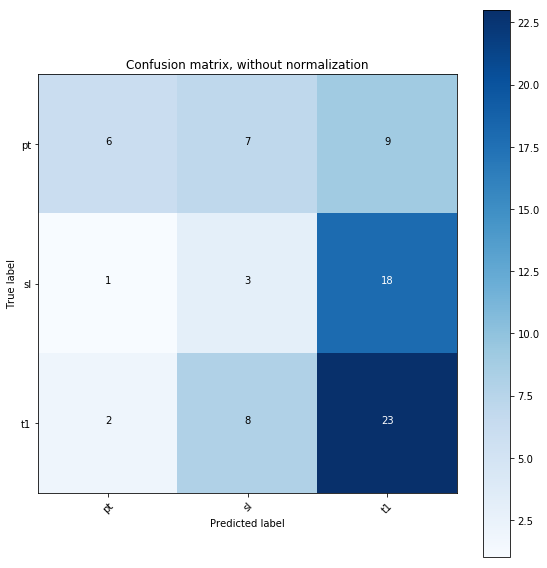

In [27]:
# Make predictions and plot confusion matrix
y_preds_flat = pd.DataFrame(model.predict(X_test_bit), columns=['pt','sl','t1']).idxmax(1)
y_test_flat = pd.DataFrame(y_test_bit, columns=['pt','sl','t1']).idxmax(1)
cnf_matrix = confusion_matrix(y_test_flat, y_preds_flat)
class_names=['pt','sl','t1']
sns.set()
plt.figure(figsize=(8,8))
mlu.plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

## Conclusions
The confusion matrix above shows how well the model predicts the outcome of trades for Bitcoin. The model does well predicting when the market will move sideways after a trade. Even better, it correctly identifies a number of profitable trading opportunities. This model is using symmetric targets on either side, so short positions could be generated as well. The data used for this analysis was not trained on, so the chance of overfitting is low. While the results may not appear outstanding, this is a good start and no tuning or feature engineering was done. The test shows some benefit in using additional assets to train a model and much greater results would be expected with more data and more time for designing better model architectures and features.